In [1]:
import numpy as np
import random as rnd
import scipy.spatial.distance as distance
import math
import scipy.stats as stats
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plot
import scipy
import random
import itertools
import traceback
import matplotlib as mpl
import time


In [2]:
# import time


# class Timer(object):
#     def __init__(self, verbose=False, _time_duration=None):
#         self.verbose = verbose
#         self.start_time = None
#         if _time_duration:
#             if isinstance(_time_duration, int) or isinstance(_time_duration, float):
#                 self._time_duration = int(_time_duration)
#             else:
#                 raise ValueError("Unknown data format for time_duration")
    
#     def __enter__(self):
#         self.start = time.time()
#         return self

#     def start(self):
#         if not self.start_time:
#               self.start_time = time.time()

#       def expired(self):
#     return self.elapsed() >= self._time_duration

#   def elapsed(self):
#     return time.time() - self.start_time

#   def __exit__(self, *args):
#     self.end = time.time()
#     self.secs = self.end - self.start
#     self.msecs = self.secs * 1000  # millisecs
#     if self.verbose:
#       name = ""
#       if args.has_key("name"):
#         name = args["name"]
#       print name + ' elapsed time: %f ms' % self.msecs

In [3]:
#Calculate mahalanobis distance
def myMahalanobis(x, mu, alpha):
    try:
        return abs(np.matmul((x - mu).transpose(),np.matmul(alpha, x - mu)))
    except ValueError:
        print("alpha = {}, x = {}, mu = {}".format(alpha, x, mu))

In [4]:
# create a new component (representative of a multivariate gaussian distribution)
def create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, x):
    accumulators[K] = 1
    ages[K] = 1
    alphas[K] = sigmaInv * np.identity(len(alphas[0]))
    comProbs[K] = 1 / sum(accumulators.values())
    covDets[K] = np.linalg.det(alphas[K]) ** -1
    mus[K] = 0 + x
    K += 1
    return K


In [5]:
# update a component j using the posterior probabilities of data point x
#Algorithm 2 update
def update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, x):
    dist = (myMahalanobis(x, mus[j], alphas[j]))
    
    pxj = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[j])) 
    pxj *= math.exp(-0.5 * dist)#
   
    if printing:
        print(pxj)
    
    pjx = pxj * comProbs[j]#
    totProbs = 0
    for i in range(K):
        pxi =  1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[i])) 
        pxi *= math.exp(-0.5 * dist)#
        totProbs += pxi * comProbs[i]#
        
    if totProbs == 0:
        print(comProbs)
        print()
    try:
            pjx /= totProbs# 
    
    except ZeroDivisionError as err:
        print(str(err) + traceback.format_exc() + "pjx = {}, totProbs = {}".format(pjx, totProbs))
        
        
    if printing:
        print(pjx)
    
    ages[j] += 1
    accumulators[j] += pjx
    
    ej = x - mus[j]
    weight = pjx / accumulators[j]
    
    deltaMu = weight * ej
    mus[j] += deltaMu

    oldAlpha = alphas[j]
    
    inputLen = len(ej)
    e = np.ndarray([inputLen,1])
    for i in range(inputLen):
        e[i,0] = ej[i]
    ej = e
    
    newAlpha = np.matmul(oldAlpha, np.matmul(ej, np.matmul(np.transpose(ej), oldAlpha)))
    newAlpha *= (weight * (1 - 3 * weight + weight ** 2)) / ((weight - 1) ** 2 * (weight ** 2 - 2 * weight - 1))
    alphas[j] = newAlpha + oldAlpha / (1 - weight)
            
    comProbs[j] = accumulators[j] / sum(accumulators.values())
    
    covDets[j] = (1 - weight) ** D * covDets[j] * (1 + (weight * (1 + weight * (weight - 3)))/(1 - weight) * np.matmul(ej.transpose(), np.matmul(oldAlpha, ej)))

    return mus
    

In [6]:
# remove a component after it was merged with another component in the model
def remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK):
    
    for i in range(j,len(ages) - 1):
        accumulators[i] = accumulators.pop(i + 1)
        ages[i] = ages.pop(i + 1)
        alphas[i] = alphas.pop(i + 1)
        comProbs[i] = comProbs.pop(i + 1)
        correspondingData[i] = correspondingData.pop(i + 1)
        covDets[i] = covDets.pop(i + 1)
        mus[i] = mus.pop(i + 1)
    
    return removeHelper(comProbs, accumulators)

In [7]:
def removeHelper(comProbs, accumulators):
    val = len(accumulators)
    for i in range(val):
        summed = 0
        for j in range(val):
            summed += accumulators[j]
        comProbs[i] = accumulators[i] / summed
    return comProbs

In [8]:
# generate data from 5 normal gaussian distributions
#set plotting to True to see the scatter plots of generated data
def generateData3(plotting = False):
    D = 4; K = 0; Beta = 0.05; delta = 0.01
    vmin = 5; spmin = 3
    mus = np.ndarray([D + 1,2]); sigmas = np.ndarray([D+1,2,2])
    mus = np.array([[1, 1], [10, 10], [10,1], [1,10], [5,5]])
    
    for i in range(D + 1):
        sigmas[i] = [[1, 0], [0, 1]]

    startingMus = mus
    numvectors = 1500; lenvectors = 2
    X = np.ndarray((numvectors, lenvectors))
    startingCorrespondences = []
    
    maxZ = 0
    count = 0
    for i in range(numvectors):
        distant = False
        index = random.randint(0,4)
        startingCorrespondences.append(index)
        X[i] = np.random.multivariate_normal(mus[index], sigmas[index])
        for j in range(lenvectors):
            ZScore = (X[i][j] - mus[index][j]) / sigmas[index][j,j]
            if abs(ZScore) > 3:
                distant = True
            if abs(ZScore) > abs(maxZ):
                maxZ = ZScore
        if distant:
            count += 1
    if plotting:       
        splot = plot.subplot(1, 1, 1)

        Xs = [[],[],[],[],[]]
        Ys = [[],[],[],[],[]]
        colors = ['r','b','k','y','m']

        for i in range(len(X)):
            index = startingCorrespondences[i]
            Xs[index].append(X[i,0])
            Ys[index].append(X[i,1])
        for i in range(5):
            plot.scatter(Xs[i], Ys[i], c =colors[i])
            v, w = np.linalg.eigh(sigmas[i])
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180.0 * angle / np.pi  # convert to degree
            Xs_to_plot = Xs[i]
            Ys_to_plot = Ys[i]
            plot.scatter(Xs_to_plot, Ys_to_plot, c = colors[i])
            plot.scatter((mus[i][0]), (mus[i][1]), c = 'g')

            ell = mpl.patches.Ellipse(mus[i],v[0], v[1], 180.0 + angle, color=colors[i % 5])
            ell.set_clip_box(splot.bbox)

            ell.set_alpha(0.5)
            splot.add_artist(ell)

    return [X, startingMus, sigmas, startingCorrespondences, maxZ, count/numvectors]
# return the generated data, and the mus and sigmas of the gaussians used to generate the data

In [31]:
# simulate the IGMM process for input data stream X
# set printing parameter to true to see final correspondences from the IGMM generated mus to the mus used in data generation
def simulate(X, sigmas, startingMus, delta = 1, dimension = 2, vmin = 5, spmin = 3, printing = False):
    beta = 0.25
    sigma = beta * np.std(X[:100]) #sigma should be representative of only a part of the data stream
    sigmaInv = sigma ** -1    
    alpha = sigmaInv * np.identity(dimension)
    covarDet = np.linalg.det(np.linalg.inv(alpha))
    mDistMax = 10#5 * sigma
    D = dimension
    
    alphas = {}
    mus = {}
    covDets = {}
    comProbs = {}
    ages = {}
    accumulators ={}
    correspondingData = {}
    ZDict = {}

    alphas[0] = alpha
    covDets[0] = covarDet
    mus[0] = X[0]
    comProbs[0] = 1
    ages[0] = 1
    accumulators[0] = 1
    K = 1
    remainingK = len(startingMus) + 4
    correspondingData[0] = [0]
    correspondingData[-1] = []
    correspondingData[-2] = []
    
    for i in range(len(X)):
        ZDict[i] = []
        if i == 0:
            continue
        updated = False

        for j in range(K):
            if j >= K:
                break
#             if (ages[j] > vmin) and (accumulators[j] < spmin):
#                 comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK)
#                 remainingK += 1
#                 K -= 1
                
#                 if printing:
#                     print('call remove')
#                     print()

        for j in range(K):
            if i == j:
                continue

            
            dist = (myMahalanobis(X[i], mus[j], alphas[j]))
            if printing:
                print('(' + str(i) + ', ' + str(j) + ')')
                print(dist)
            if dist < mDistMax:
                if printing:
                    print('call update')
                    print()
                correspondingData[j].append(i)
                ZDict[i].append(getZScores(X[i], mus[j], np.linalg.inv(alphas[j]), dist))
                mus = update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, X[i])
                #print('mu3 = {}'.format(mus[j]))
                #print()
                updated = True

#         if K > 1:
#             for i1 in range(K):
#                 for j1 in range(i):
#                     if i1 == j1:
#                         continue
#                     if i1 < K and j1 < K:
#                         comDist1 = myMahalanobis(mus[i1], mus[j1], alphas[j1])
#                         comDist2 = myMahalanobis(mus[j1], mus[i1], alphas[i1])
#                         comDist = comDist1  + comDist2
#                         if comDist < 5:
                            
#                             #print('merged')
#                             #print('i = {}, j = {}, meani = {}, meanj = {}'.format(i1, j1, mus[i1], mus[j1]))
#                             #print()
#                             for k in correspondingData[j1]:
#                                 #print('correspondingData = {}'.format(correspondingData[i1]))
#                                 #print('correspondingData = {}'.format(correspondingData[j1]))
#                                 if k not in correspondingData[i1]:
#                                     dist = (myMahalanobis(X[k], mus[i1], alphas[i1]))
#                                     if dist < mDistMax:
#                                         ZDict[k].append(getZScores(X[k], mus[i1], np.linalg.inv(alphas[i1]), dist))
#                                         mus = update(accumulators, ages, alphas, comProbs, covDets, D, i1, K, mus, printing, X[k])
#                                         correspondingData[i1].append(k)
#                                         correspondingData[j1].remove(k)
#                                     else:
#                                         updatedMerge = False
#                                         for f in range(K):
#                                             if f == i1 or f == j1:
#                                                 continue
#                                             else:
#                                                 dist = myMahalanobis(X[k], mus[f], alphas[f])
#                                                 if dist <mDistMax:
#                                                     mus = update(accumulators, ages, alphas, comProbs, covDets, D, f, K, mus, printing, X[k])
#                                                     updatedMerge = True
#                                         if not updatedMerge:
#                                             correspondingData[-2].append(k)
                                            
#                                 #print('correspondingData = {}\n'.format(correspondingData[i1]))
#                             comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j1, mus, remainingK)
#                             remainingK += 1
#                             K -= 1
         ## end !!!!!!
    
        
        if not updated and remainingK == 0:
            correspondingData[-1].append(i)
        
        if not updated and not remainingK == 0:
            if printing:
                print('call create')
                print()
            correspondingData[K] = [i]
            K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, X[i])
            remainingK -= 1
            
    oldZDict = {}
    #if correspondingData[-1]:
    #    [alphas, correspondingData, mus, K, comProbs, covDets, ZDict, oldZDict] = simulateMature(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mus, X[correspondingData[-1]], ZDict, mDistMax = 20)

    if printing:
        print(K)
    norms = np.ndarray([D + 1, K])
    difference = 0
    correspondences = np.ndarray(D + 1)
    for i in range(D + 1): #D + 1 = len(startingMus)
        for j in range(K):
            norms[i, j] = np.linalg.norm(startingMus[i] - mus[j])
        index = np.argmin(norms[i])
        difference += norms[i,index]
        correspondences[i] = index
        
        if printing:
            print("mu = {}, sigma = {}".format(mus[index], np.linalg.inv(alphas[index])))
            print("starting mu = {}, starting Sigma = {}".format(startingMus[i], sigmas[i]))
            print("corresponding data = {}\n".format(correspondingData[index]))


    if printing:
        print(str(difference) + '\n')
        print(correspondingData)
    
    print(K)
    oldK = K        
    K = mergeClusters(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mDistMax, mus, remainingK, sigmaInv, X, ZDict)
    remainingK -= (K - oldK)
    print(K)
    
    oldK = K
    K = splitClusters(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mDistMax, mus, remainingK, sigmaInv, X)
    remainingK -= (K - oldK)
    
    print(K)
    oldK = K        
    K = mergeClusters(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mDistMax, mus, remainingK, sigmaInv, X, ZDict)
    remainingK -= (K - oldK)
    print(K)
    return [alphas, correspondingData, difference, mus, K, comProbs, covDets, ZDict, oldZDict, accumulators]


In [25]:
def splitClusters(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mDistMax, mus, remainingK, sigmaInv, X):
    doneSplitting = False
    while not doneSplitting:
        doneSplitting = True
        for j in range(K):
            
            if remainingK <= 0:
                doneSplitting = True
                break
            
            eigenvalues = np.linalg.eigvalsh(alphas[j])
            total_values = 0
            for value in eigenvalues:
                if value != 0:
                    value = value ** -1
                total_values += value
            avg_value = total_values / (len(eigenvalues))
            num_less = 0
            for i in correspondingData[j]:
                if (mySpatialDist(X[i], mus[j])) < avg_value:
                    #if (np.linalg.norm(X[i] - mus[j])) < avg_value:
                    num_less += 1
            ratio_less = num_less / len(correspondingData[j])
            if ratio_less > 0.5:
                doneSplitting = False
                splitX = correspondingData[j].copy()
                comProbs = remove (accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK)
                K -= 1
                remainingK += 1
                #comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j2, mus, remainingK)
                random.shuffle(splitX)
                oldK = K
                K = splitClustersHelper(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, j, K, mDistMax, splitX, mus, remainingK, sigmaInv, X)
                remainingK -= (K - oldK)
                #print(K)
                #print(oldK)
                break
    return K

In [11]:
#Function to take points from two clusters and use igmm to create one cluster from them
#Note: not tracking ZScores
def splitClustersHelper(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, j, K, mDistMax, splitX, mus, remainingK, sigmaInv, X):
    correspondingData[K] = [splitX[0]]
    K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, X[splitX[0]])
    oldK = K
    remainingK = 2

    for i in range(1, len(splitX)):
        updated = False
        for j1 in range(oldK - 1, K):
            dist = myMahalanobis(X[splitX[i]], mus[j1], alphas[j1])
            if dist < mDistMax:
                updated = True
                correspondingData[j1].append(splitX[i])
                #ZDict[i].append(getZScores(X[mergeX[i]], mus[K - 1], np.linalg.inv(alphas[K - 1]), dist))
                mus = update(accumulators, ages, alphas, comProbs, covDets, D, j1, K, mus, False, X[splitX[i]])

        if (not updated) and remainingK > 0:
                correspondingData[K] = [splitX[i]]
                K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, X[splitX[i]])
                remainingK -= 1

        elif not updated:
            correspondingData[-1].append(splitX[i])

    return K

In [41]:
def mergeClusters(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mDistMax, mus, remainingK, sigmaInv, X, ZDict):
    doneMerging = False
    maxDist = mDistMax * 2
    while not doneMerging:
        doneMerging = True
        for i in range(K):
            if i >= K:
                break
                
            for j in range(i):
                if j >= K or i >= K:
                    break
                dist1 = myMahalanobis(mus[i], mus[j], alphas[j])
                dist2 = myMahalanobis(mus[j], mus[i], alphas[i])
                dist = (dist1 + dist2) / 2
                if dist < maxDist:                    
                    doneMerging = False
                    points = correspondingData[j] #look at all points in j
                    for x in correspondingData[i]:
                        if x not in points:
                            points.append(x) #look at all points in i not in j

                    random.shuffle(points)
                    K = mergeClustersHelper(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, i, j, K, mDistMax, points, mus, remainingK, sigmaInv, X, ZDict)
                    remainingK += 1
                    
    return K

In [13]:
#Function to take points from two clusters and use igmm to create one cluster from them
#Note: not tracking ZScores
def mergeClustersHelper(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, j1, j2, K, mDistMax, mergeX, mus, remainingK, sigmaInv, X, ZDict):
    comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j1, mus, remainingK)
    K -= 1; remainingK += 1
    comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j2, mus, remainingK)
    K -= 1; remainingK += 1
    correspondingData[K] = [mergeX[0]]
    K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, X[mergeX[0]])
    
    for i in range(1, len(mergeX)):
        dist = myMahalanobis(X[mergeX[i]], mus[K-1], alphas[K-1])
        if dist < mDistMax:
            correspondingData[K - 1].append(mergeX[i])
            #ZDict[i].append(getZScores(X[mergeX[i]], mus[K - 1], np.linalg.inv(alphas[K - 1]), dist))
            mus = update(accumulators, ages, alphas, comProbs, covDets, D, K - 1, K, mus, False, X[mergeX[i]])
            
        else:
            correspondingData[-1].append(mergeX[i])
    
    return K

In [14]:
def getSoftProbs(alphas, comProbs, covDets, K, mus, Xini):
    X = np.copy(Xini)
    D = K - 1
    softProbs = np.ndarray([len(Xini),K])
    probs = np.ndarray([K])
    for i in range(len(Xini)):
        for j in range(K):
            dist = (myMahalanobis(X[i], mus[j], alphas[j]))
            probs[j] = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[j])) * math.exp(-0.5 * dist) * comProbs[j]

        probsum = sum(probs)
        
        for j in range(K):
            try:
                softProbs[i,j] = math.exp (math.log(probs[j]) - math.log(probsum))
            except ValueError:
                softProbs[i,j] = 0
    return softProbs

In [15]:
def getZScores(x, mu, sigma, dist):
    ZScores = [dist]
    for i in range(len(x)):
        ZScores.append(((x[i] - mu[i]) / sigma[i,i]))
    return ZScores

In [16]:
def mySpatialDist(x1, x2):
    tot = 0
    for i in range(len(x1)):
        tot += (x1[i] - x2[i]) ** 2
    if tot > 0:
        return tot ** (1/2)
    else:
        return 0
        
        

In [34]:
def getOutliers(correspondingData, K):
    notOutliers = correspondingData[0]
    for j in range(1,K):
        for i in correspondingData[j]:
            if i not in notOutliers:
                notOutliers.append(i)
    for i in correspondingData[-1]:
        if i in notOutliers:
            correspondingData[-1].remove(i)

(1500, 2)
10
4
9
4


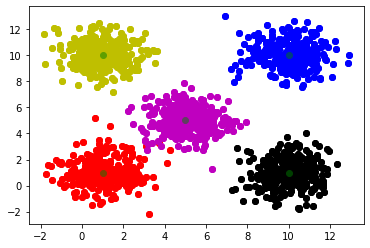

In [49]:
Data = generateData3(True) #generate some data without plotting it
Xini = np.copy(Data[0]) #save a copy of the input datastream (avoid losing it during update)
print(np.shape(Xini))

#t0 =time.process_time()
[alphas, correspondingData, difference, mus, K, comProbs, covDets, ZDict, oldZDict, accumulators] = simulate(X = Data[0], sigmas = Data[2], startingMus = Data[1], printing = False)
#print(time.process_time() - t0)

newSigmas = []
for i in range(len(alphas)):
    newSigmas.append(np.linalg.inv(alphas[i]))
#t1 = time.process_time()
M = GaussianMixture(n_components = 5, covariance_type = 'full').fit(np.copy(Xini))
#print(time.process_time() - t1)
#print(M.means_)
#print(mus)
#print()



In [29]:
print(accumulators)
for i in range(len(accumulators)):
    print(len(correspondingData[i]))
print(alphas)

{0: 15.977038098938586, 1: 11.014713146059888, 2: 9.953322977614105, 3: 57.528299612740916, 4: 16.663017887144118}
295
294
279
317
300
{0: array([[ 1.00009823e+00, -5.95897598e-04],
       [-5.95897598e-04,  1.21344928e+00]]), 1: array([[ 1.00371646, -0.02837431],
       [-0.02837431,  0.97792476]]), 2: array([[1.09124989, 0.03431435],
       [0.03431435, 0.91329116]]), 3: array([[ 1.06911642, -0.1940544 ],
       [-0.1940544 ,  1.14349043]]), 4: array([[ 0.98843259, -0.00950417],
       [-0.00950417,  0.82987321]])}


978
658
4


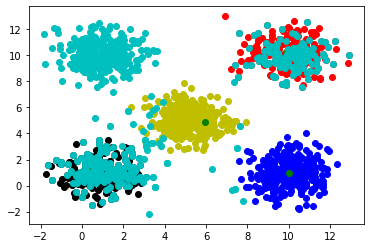

In [50]:
#Some code for plotting that needs to be turned into a new funtion
colors = ['r', 'b', 'y', 'k', 'm', 'c']
for i in range(len(mus)):
    plot.figure(1)
    A = correspondingData[i]
    
    Xs_to_plot = Xini[A,0]
    Ys_to_plot = Xini[A,1]
    plot.scatter(Xs_to_plot, Ys_to_plot, c = colors[i % 6])
    plot.scatter((mus[i][0]), (mus[i][1]), c = 'g')
print(len(correspondingData[-1]))
getOutliers(correspondingData, K)
print(len(correspondingData[-1]))
A = correspondingData[-1]
Xs_to_plot = Xini[A,0]
Ys_to_plot = Xini[A,1]
plot.scatter(Xs_to_plot, Ys_to_plot, c = 'c')
#Xs_to_plot = Xini[correspondingData[-1,0]]
#Ys_to_plot = Xini[correspondingData[-1,1]]
#plot.scatter(Xs_to_plot, Ys_to_plot, 'orange')
print(len(mus))

In [ ]:
for i in range(K):
    print(len(correspondingData[i]))
    print(comProbs[i])
    print("the {}th mu = {}".format(i,mus[i]))
    print("the {}th sigma = {}\n".format(i,np.linalg.inv(alphas[i])))


In [ ]:
print(correspondingData[-1])

In [ ]:
matchedMus = {}
newAlphas = {}
newComProbs = {}
newCovDets = {}

for i in range(len(mus)):
    distances = []
    for j in range(len(M.means_)):
        distances.append(np.linalg.norm(M.means_[j] - mus[i]))
    matchedMus[distances.index(min(distances))] = mus[i]
    newAlphas[distances.index(min(distances))] = alphas[i]
    newComProbs[distances.index(min(distances))] = comProbs[i]
    newCovDets[distances.index(min(distances))] = covDets[i]

newSigmas = {}
for i in range(len(newAlphas)):
    newSigmas[i] = np.linalg.inv(newAlphas[i])


newData = generateData3(False)#generate some data without plotting i
Xnew = newData[0]
softProbs = getSoftProbs(newAlphas, newComProbs, newCovDets, K, matchedMus, Xnew)
#print(softProbs)
sPArr = []
for i in range(len(softProbs)):
    sPArr.append(np.argmax(softProbs[i]))

#print(sPArr)
batch = M.predict(Xnew)
#print(batch)

startingMus = newData[1]
startingSigmas = newData[2]
startingCorrespondences = newData[3]

matchedStartingSigmas = {}
matchedStartingMus = {}
componentMap = {}
for i in range(len(startingMus)):
    distances = []
    for j in range(len(M.means_)):
        distances.append(np.linalg.norm(startingMus[i] - M.means_[j]))
    matchedStartingMus[distances.index(min(distances))] = startingMus[i]
    matchedStartingSigmas[distances.index(min(distances))] = startingSigmas[i]
    componentMap[i] = (distances.index(min(distances)))
startingMus = matchedStartingMus
startingSigmas = matchedStartingSigmas
    
for i in range(len(mus)):
    print("{}th starting mu = {}".format(i,startingMus[i]))
    print("{}th incremental mu = {}".format(i,matchedMus[i]))
    print("{}th batch mu = {}".format(i, M.means_[i]))
    print()
    print("{}th starting sigma = {}".format(i, startingSigmas[i]))
    print("{}th incremental sigma = {}".format(i, newSigmas[i]))
    print("{}th batch sigma = {}".format(i, M.covariances_[i]))
    print("\n\n")

for i in range(len(startingCorrespondences)):
    startingCorrespondences[i] = componentMap[startingCorrespondences[i]]

#print(startingCorrespondences)
bCount = 0
iCount = 0
for i in range(len(sPArr)):
    if sPArr[i] == startingCorrespondences[i]:
        iCount += 1
    if batch[i] == startingCorrespondences[i]:
        bCount += 1
iAcc = iCount / len(startingCorrespondences) * 100
bAcc = bCount / len(startingCorrespondences) * 100
print("The IGMM was {}% accurate.".format(iAcc))
print("The batch GMM was {}% accurate.".format(bAcc))


In [ ]:
def slowCreate(accumulators, ages, comProbs, covariance, covMats, K, mus, x):
    accumulators[K] = 1
    ages[K] = 1
    covMats[K] = covariance * np.identity(len(covMats[0]))
    comProbs[K] = 1 / sum(accumulators.values())
    mus[K] = 0 + x
    return K + 1
    

In [ ]:
def slowUpdate(accumulators, ages, comProbs, covMats, D, j, K, mus, printing, x):
    dist = myMahalanobis(x, mus[j], np.linalg.inv(covMats[j]))
    try:
        pxj = 1 / ( (2 * math.pi) ** (D / 2)  * math.sqrt(np.linalg.det(covMats[j]))) 
    except ValueError:
        print("covariance = {}".format(covMats[j]))
    pxj *= math.exp(-0.5 * dist)
    pjx = pxj * comProbs[j]
    totProbs = 0
    for i in range(K):
        pxi = 1 / ((2 * math.pi) ** (D / 2)) * math.sqrt(np.linalg.det(covMats[i])) 
        pxi *= math.exp(-0.5 * dist)
        totProbs += pxi * comProbs[i]
    
    pjx /= totProbs
    ages[j] += 1
    accumulators[j] += pjx
    
    ej = x - mus[j]
    weight = pjx / accumulators[j]
    
    deltaMu = weight * ej
    mus[j] += deltaMu
    
    ejstar = x - mus[j]
    
    covMats[j] = (1 - weight) * covMats[j] + weight * ejstar * np.transpose(ejstar) - deltaMu * np.transpose(deltaMu)
    accSum = 0
    for i in range(K):
        accSum += accumulators[i]
    comProbs[j] = accumulators[j] / accSum 
    
    return mus

In [ ]:
def slowRemove(accumulators, ages, comProbs, correspondingData, j, mus):
    
    for i in range(j, len(ages) - 1):
        accumulators[i] = accumulators.pop(i + 1)
        ages[i] = ages.pop(i + 1)
        comProbs[i] = comProbs.pop(i + 1)
        covMats[i] = covMats.pop(i + 1)
        mus[i] = mus.pop(i + 1)
    
    comProbs = removeHelper(comProbs, accumulators)

In [ ]:
# simulate the IGMM process for input data stream X
# set printing parameter to true to see final correspondences from the IGMM generated mus to the mus used in data generation
def slowSimulate(X, sigmas, startingMus, delta = 1, dimension = 2, D = 4, vmin = 5, spmin = 3, printing = False):
    sigma = np.std(X[:100]) #sigma should be representative of only a part of the data stream
    variance = sigma ** 2    
    covar = variance * np.identity(dimension)
    mDistMax = 0.2 * sigma #5 * sigma
    print("mDistMax = {}".format(mDistMax))
    covMats = {0:covar}
    mus = {0:X[0]}
    comProbs = {0:1}
    ages = {0:1}
    accumulators ={0:1}
    correspondingData = {0:[0], -1:[],-2:[]}
    ZDict = {0:[]}
    K = 1
    remainingK = D

    
    for i in range(len(X)):
        ZDict[i] = []
        if i == 0:
            continue
        updated = False

        for j in range(K):
            if j >= K:
                break


        for j in range(K):
            if i == j:
                continue

            
            dist = (myMahalanobis(X[i], mus[j], np.linalg.inv(covMats[j])))
            if printing:
                print('(' + str(i) + ', ' + str(j) + ')')
                print(dist)
            if dist < mDistMax:
                if printing:
                    print('call update')
                    print()
                correspondingData[j].append(i)
                ZDict[i].append(getZScores(X[i], mus[j], covMats[j], dist))
                mus = slowUpdate(accumulators, ages, comProbs, covMats, D, j, K, mus, printing, X[i])
                #print('mu3 = {}'.format(mus[j]))
                #print()
                updated = True

        if K > 1:
            for i1 in range(K):
                for j1 in range(i):
                    if i1 == j1:
                        continue
                    if i1 < K and j1 < K:
                        mat = (covMats[i1] + covMats[j1]) / 2
                        alp = np.linalg.inv(mat)
                        comDist = (myMahalanobis(mus[i1], mus[j1], alp))
                        if comDist < 0.05:
                            
                            #print('merged')
                            #print('i = {}, j = {}, meani = {}, meanj = {}'.format(i1, j1, mus[i1], mus[j1]))
                            #print()
                            for k in correspondingData[j1]:
                                #print('correspondingData = {}'.format(correspondingData[i1]))
                                #print('correspondingData = {}'.format(correspondingData[j1]))
                                if k not in correspondingData[i1]:
                                    dist = (myMahalanobis(X[k], mus[i1], np.linalg.inv(covMats[i1])))
                                    if dist < mDistMax:
                                        ZDict[k].append(getZScores(X[k], mus[i1], covMats[i1], dist))
                                        mus = slowUpdate(accumulators, ages, comProbs, covMats, D, i1, K, mus, printing, X[k])
                                        correspondingData[i1].append(k)
                                        correspondingData[j1].remove(k)
                                    else:
                                        correspondingData[-2].append(k)
                                #print('correspondingData = {}\n'.format(correspondingData[i1]))
                            comProbs = slowRemove(accumulators, ages, comProbs, covDets, correspondingData, covDets, j1, mus)
                            remainingK += 1
                            K -= 1
         ## end !!!!!!
    
        if not updated and remainingK == 0:
            correspondingData[-1].append(i)
        
        if not updated and not remainingK == 0:
            if printing:
                print('call create')
                print()
            correspondingData[K] = [i]
            K = slowCreate(accumulators, ages, comProbs, covar, covMats, K, mus, X[i])
            remainingK -= 1
            

    #if correspondingData[-1]:
    #    [alphas, correspondingData, mus, K, comProbs, covDets, ZDict, oldZDict] = simulateMature(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mus, X[correspondingData[-1]], ZDict, mDistMax = 20)

    if printing:
        print(K)
    norms = np.ndarray([D + 1, K])
    difference = 0
    correspondences = np.ndarray(D + 1)
    for i in range(D + 1): #D + 1 = len(startingMus)
        for j in range(K):
            norms[i, j] = np.linalg.norm(startingMus[i] - mus[j])
        index = np.argmin(norms[i])
        difference += norms[i,index]
        correspondences[i] = index
        
        if printing:
            print("mu = {}, sigma = {}".format(mus[index], covMats[i]))
            print("starting mu = {}, starting Sigma = {}".format(startingMus[i], sigmas[i]))
            print("corresponding data = {}\n".format(correspondingData[index]))


    if printing:
        print(str(difference) + '\n')
        print(correspondingData)
            

    return [covMats, correspondingData, difference, mus, K, comProbs, ZDict]


In [ ]:
# simulate the igmm and calculate the distance from the resulting means to the original means, then roll the input matrix
# and repeat until we minimize the distance between the resulting means and original means
# number of trials determines how many times we roll the matrix and test
#TODO verify this code works correctly
def sieve(Data, K = 5, D = 4, printing = False, trials = 50): 
    
    savedData = np.copy(Data)
    differences = np.ndarray(trials)
    X = Data[0]; sigmas = Data[2]; startingMus = Data[1]
    
    for t in range(trials):
        [alphas, correspondingData, difference, mus, K, comProbs, covDets, zDict] = simulate(X = Data[0], sigmas = Data[2], startingMus = Data[1], printing = False)

    
        norms = np.ndarray([D + 1, K])
        difference = 0
        correspondences = np.ndarray(D + 1)

        for i in range(D + 1): #D + 1 = len(startingMus)
            for j in range(K):
                norms[i, j] = (np.linalg.norm(startingMus[i] - mus[j])) ** 2
            index = np.argmin(norms[i])
            difference += norms[i,index]
            correspondences[i] = index
            if printing:    
                print("mu = {}, sigma = {}".format(mus[index], np.linalg.inv(alphas[index])))
                print("starting mu = {}, starting Sigma = {}".format(startingMus[i], sigmas[i]))
                print("corresponding data = {}\n".format(correspondingData[index]))


        if printing:
            print(str(difference) + '\n')
            print(correspondingData)

        if t == 0:
            mindifference = difference
            besti = 0

        elif mindifference > difference:
            mindifference = difference
            besti = t

        differences[t] = difference

        Data = np.copy(savedData)
        X = np.roll(Data[0],1); sigmas = Data[2]; startingMus = Data[1]


    return [mindifference, besti, differences]

In [ ]:
# Takes in an array of outliers and calculates their posterior probabilities for each of the gaussians produced by the IGMM

def getSoftProbsOut(alphas, comProbs, covDets, K, mus, outliers, Xini):
    X = np.copy(Xini)
    D = K - 1
    softProbs = np.ndarray([len(outliers),K])
    probs = np.ndarray([K])
    for i in range(len(outliers)):
        for j in range(K):
            dist = (myMahalanobis(X[i], mus[j], alphas[j]))
            probs[j] = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[j])) * math.exp(-0.5 * dist) * comProbs[j]

        probsum = sum(probs)
        
        for j in range(K):
            softProbs[i,j] = probs[j] / probsum
    return softProbs
        
    

In [ ]:
Data = generateData3(True)
startingMus = Data[1]
startingSigmas = Data[2]
Xini = np.copy(Data[0])
[covMats, correspondingData, difference, mus, K, comProbs, ZDict] = slowSimulate(X = Data[0], sigmas = Data[2], startingMus = Data[1], printing = False)

In [ ]:
#Some code for plotting that needs to be turned into a new funtion
colors = ['r', 'b', 'y', 'k', 'm']
for i in range(len(mus)):
    plot.figure(1)
    A = correspondingData[i]
    
    Xs_to_plot = Xini[A,0]
    Ys_to_plot = Xini[A,1]
    plot.scatter(Xs_to_plot, Ys_to_plot, c = colors[i % 5])
    plot.scatter((mus[i][0]), (mus[i][1]), c = 'g')


In [ ]:
M = GaussianMixture(n_components = 5, covariance_type = 'full').fit(np.copy(Xini))

matchedMus = {}
matchedCovMats = {}
matchedComProbs = {}

for i in range(len(mus)):
    distances = []
    for j in range(len(M.means_)):
        distances.append(np.linalg.norm(M.means_[j] - mus[i]))
    matchedMus[distances.index(min(distances))] = mus[i]
    matchedCovMats[distances.index(min(distances))] = covMats[i]
    matchedComProbs[distances.index(min(distances))] = comProbs[i]


matchedStartingSigmas = {}
matchedStartingMus = {}
componentMap = {}
for i in range(len(startingMus)):
    distances = []
    for j in range(len(M.means_)):
        distances.append(np.linalg.norm(startingMus[i] - M.means_[j]))
    matchedStartingMus[distances.index(min(distances))] = startingMus[i]
    matchedStartingSigmas[distances.index(min(distances))] = startingSigmas[i]
    componentMap[i] = (distances.index(min(distances)))
startingMus = matchedStartingMus
startingSigmas = matchedStartingSigmas
    
for i in range(len(mus)):
    print("{}th starting mu = {}".format(i,matchedStartingMus[i]))
    print("{}th incremental mu = {}".format(i,matchedMus[i]))
    print("{}th batch mu = {}".format(i, M.means_[i]))
    print()
    print("{}th starting sigma = {}".format(i, startingSigmas[i]))
    print("{}th incremental sigma = {}".format(i, matchedCovMats[i]))
    print("{}th batch sigma = {}".format(i, M.covariances_[i]))
    print("\n\n")

In [ ]:
#create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, x):
#update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, x):
accumulators = {0:1}; ages = {0:1}; alphas = {0:1.*np.identity(2)}; comProbs ={0:1.}; covDets = {0:1.}; K = 1; mus = {0:(np.array([1.,1.]))}
sigmaInv = 1; dimension = 2
x1 = np.array([10.,10.]); x2 = np.array([1.1,1.1]); x3 = np.array([9.,9.])
K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, x1)
print(comProbs[1])
print(comProbs[0])
mus = update(accumulators, ages, alphas, comProbs, covDets, dimension, 0, K, mus, False, x2)
print(comProbs[0])
print()
mus = update(accumulators, ages, alphas, comProbs, covDets, dimension, 1, K, mus, False, x3)
print(comProbs[1])

In [ ]:
# def removeHelper(comProbs, accumulators):
#     summed = sum(accumulators.values())
#     for i in range(len(comProbs)):
#         comProbs[i] = comProbs[i] / summed
#     return comProbs

In [ ]:
# simulate the IGMM process updates for all outliers
# set printing parameter to true to see final correspondences from the IGMM generated mus to the mus used in data generation
def simulateMature(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mus, outliers, ZDict, mDistMax = 11, printing = False):
    X = outliers
    oldZDict = ZDict
    ZDict = {}
    correspondingData[-3] = []
    for i in range(len(X)):
        ZDict[i] = []
        updated = False
        distArr = []
        for j in range(K):
            dist = (myMahalanobis(X[i], mus[j], alphas[j]))
            distArr.append(dist)
            if printing:
                print('(' + str(i) + ', ' + str(j) + ')')
                print(dist)
            if dist < mDistMax:
                if printing:
                    print('call update')
                    print()
                correspondingData[j].append(i)
                ZDict[i].append(getZScores(X[i], mus[j], np.linalg.inv(alphas[j]), dist))
                mus = update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, X[i])
                updated = True

        if not updated and min(distArr) < 11:
            
            correspondingData[j].append(i)
            ZDict[i].append(getZScores(X[i], mus[j], np.linalg.inv(alphas[j]), dist))
            mus = update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, X[i])
        elif not updated:
            correspondingData[-3].append(i)
    
    return [alphas, correspondingData, mus, K, comProbs, covDets, ZDict, oldZDict]

In [ ]:
def mergeMature(accumulators, ages, alphas, comProbs, correspondingData, covDets, D, K, mDistMax, mus, remainingK, X, ZDict, printing = False):
    doneMerging = False
    while not doneMerging:
        doneMerging = True
        for i in range(K):
            if i >= K:
                continue
            for j in range(i):
                if j >= K:
                    continue
                dist1 = myMahalanobis(mus[i], mus[j], alphas[j])
                dist2 = myMahalanobis(mus[j], mus[i], alphas[i])
                dist = (dist1 + dist2) / 2
                if dist < 1.5*mDistMax:
                    for k in correspondingData[i]:
                        if k not in correspondingData[j]:
                            dist = myMahalanobis(X[k], mus[j], alphas[j])
                            if dist < mDistMax:
                                mus = update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, X[k])
                                correspondingData[j].append(k)
                                ZDict[k].append(getZScores(X[k], mus[j], np.linalg.inv(alphas[j]), dist))

                            else:
                                for f in range(K):
                                    if f == j or f == i:
                                        continue
                                    elif k in correspondingData[f]:
                                        break
                                    
                                    else:
                                        dist =  myMahalanobis(X[k], mus[f], alphas[f])
                                        if mDistMax > dist:
                                            mus = update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, X[k])
                                            correspondingData[f].append(k)
                                            ZDict[k].append(getZScores(X[k], mus[f], np.linalg.inv(alphas[f]), dist))
                                        else:
                                            correspondingData[-2].append(k)
                    comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, i, mus, remainingK)
                    K -= 1
                    doneMerging = False
    return [accumulators, ages, alphas, comProbs, correspondingData, covDets, K, mDistMax, mus, ZDict]

In [24]:
arr = [1,2,3,4]
random.shuffle(arr)
print(arr)


[1, 4, 3, 2]
